**Part 3 - Looseness prediction**

Paulo Yoshio Kuga

In [1]:
import pandas as pd
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import re
import ast



from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

*1. Extract features that might be relevant for distinguishing between a healthy and loose asset. Plot the features from the dataset using any data visualization you find relevant.*

First, we load the metadata, and using it, we can load the real data. Metadata provides a dictionary that can be used. To do this, we can associate the original channel to the same nomenclature of the dictionary. 

In [ ]:
path = './part_3/'

metadata = pd.read_csv(path + 'part_3_metadata.csv')

dictChannel = {'Ch1 Y-Axis': 'axisX', 'Ch2 Y-Axis': 'axisY','Ch3 Y-Axis': 'axisZ','X-Axis':"time"}

dataDict = {sample_id: pd.read_csv(path + "data/" + sample_id + ".csv") for sample_id in metadata["sample_id"]}

for i,file in metadata.iterrows():
    data = dataDict[file["sample_id"]]
    data.set_index("X-Axis", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"]) #the original string of the orientation becomes a dictionary
    data.columns = [dictOrientation[dictChannel[name]] for name in data.columns]

    

From previous exercises we can provide a function GenerateWelch that returns the three power densities from the signals.

In [3]:
def GenerateWelch(data,nperseg = 1024, overlap_factor = 0.75, windowP="hann" ):

    nover = int(nperseg*overlap_factor)

    data = data - data.mean()
   

    fs = data.shape[0] / data.index.max() 

    f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')

    return f, Ph, Pv, Pa

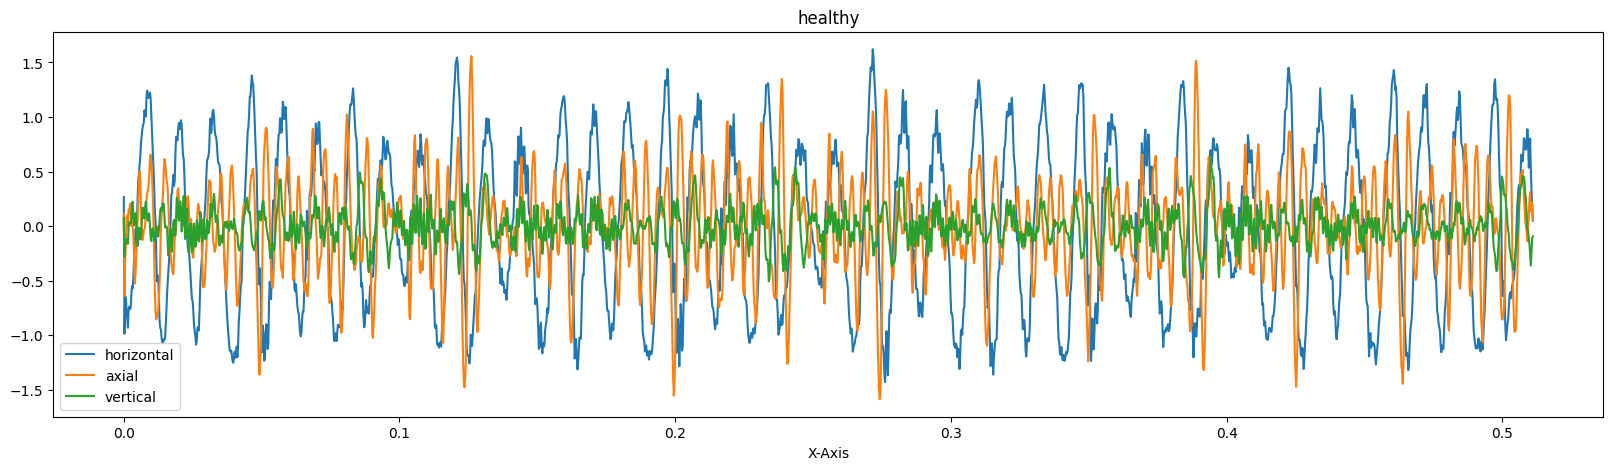

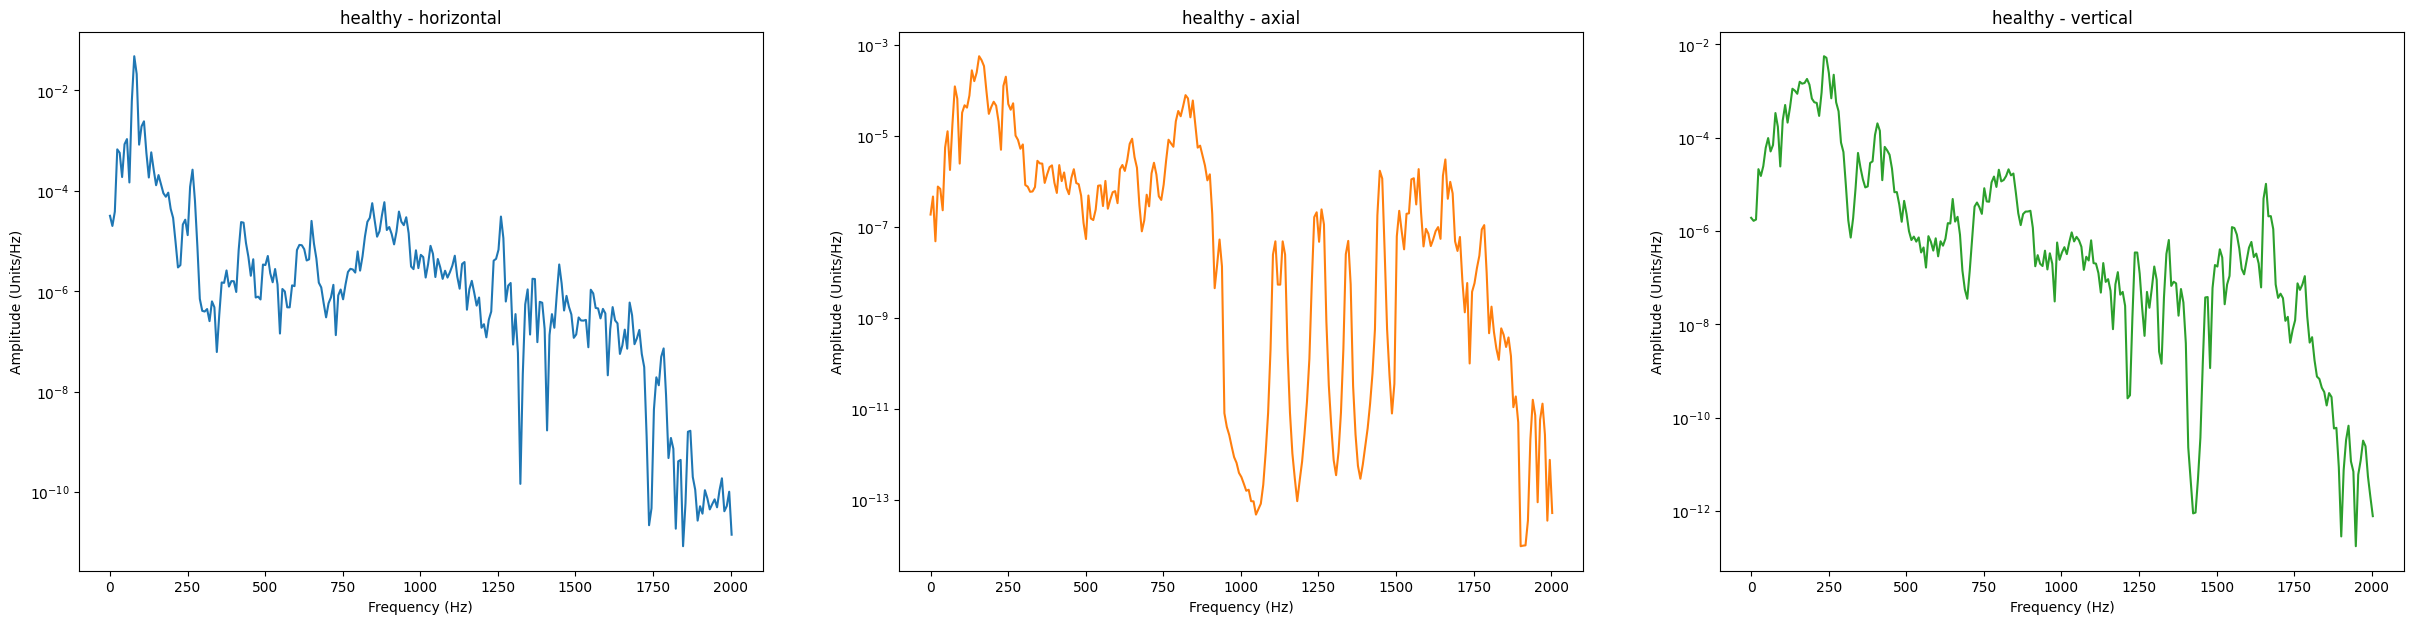

In [4]:
i = 0
w = 512
data = dataDict[metadata["sample_id"][i]]

data.plot(figsize=(20,5))
plt.title(metadata["condition"][i])

f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=w,overlap_factor=0.5)
P_g = np.array([Ph, Pv, Pa])

fig, axs = plt.subplots(1, 3, figsize=(30, 7))
for j, ax in enumerate(axs):
    ax.semilogy(f, P_g[j], color='C'+str(j))
    ax.set_title(metadata["condition"][i] + " - " + data.columns[j])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (Units/Hz)')

https://power-mi.com/content/looseness

In [5]:
def Percentual(P):
    Ph = np.log10(P)
    return (Ph-Ph.min())/(Ph.max()-Ph.min())

def SampleEnergy(data,nperseg=1024,overlap_factor=0.5):
    f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=nperseg,overlap_factor=overlap_factor)
    P_g = np.array([Percentual(Ph), Percentual(Pa), Percentual(Pv)])
    return np.sum(P_g*(f[1]-f[0]),axis=1)

SampleEnergy(data)

array([1181.71599871, 1211.07802614, 1101.13364272])

In [6]:
def get_energies(sample_id):
    return pd.Series(SampleEnergy(dataDict[sample_id]), index=["Eh","Ev","Ea"])

dataset = metadata[["sample_id","condition"]].copy()
dataset[["Eh","Ev","Ea"]] = dataset["sample_id"].apply(get_energies)

X = dataset[["Eh","Ev","Ea"]]
y = dataset["condition"]
           
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=199712115)

In [7]:
pipeToKnn = Pipeline(    
    steps=[
        ("scaler", StandardScaler()), 
        ("knn", KNeighborsClassifier()
         )
         ]
)


#parameters to be tested
param_grid = {
    "knn__n_neighbors": np.array(list(range(1, 30))),  
    "knn__weights": ["uniform", "distance"]
}

# otimizador com validação cruzada
grid = GridSearchCV(
    pipeToKnn,
    param_grid,
    cv=5, #10 fold had not changed f1                 
    scoring="f1_macro" #macro or weighted?
)

grid.fit(X_train, y_train)

pipeToKnn.set_params(**grid.best_params_)

print("Parameters:", grid.best_params_)
print("F1 Score:", grid.best_score_)

Parameters: {'knn__n_neighbors': 6, 'knn__weights': 'uniform'}
F1 Score: 0.7624065953938075


In [8]:
pipeToKnn.fit(X_train,y_train)

y_hat = pipeToKnn.predict(X_test)

#how to score: pipeToKnn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_hat))

                      precision    recall  f1-score   support

             healthy       0.76      0.80      0.78        20
structural_looseness       0.90      0.88      0.89        43

            accuracy                           0.86        63
           macro avg       0.83      0.84      0.84        63
        weighted avg       0.86      0.86      0.86        63



In [9]:
from pydantic import BaseModel, Field
from typing import List
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")

    
class LoosenessModel:
    def __init__(self, **params):
        # Store hyperparameters if needed

        defaultParams = {"windowP":"hann",
                         "nperseg":512,
                         "noverlap":256,
                         "n_neighbors":6,
                         "weights":"uniform"
                         }
    
        self.params = {**defaultParams, **params}


        
        self.Model = Pipeline(    
            steps=[
                ("scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=self.params["n_neighbors"],weights=self.params["weights"])
                )
                ]
        )
        
    def GenerateWelch(self,data):
        data = data - data.mean()
        fs = data.shape[0] / data.index.max() 

        f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=self.params["windowP"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"], scaling='density',average='median')
        _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=self.params["windowP"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"], scaling='density',average='median')
        _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=self.params["windowP"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"], scaling='density',average='median')

        return f, Ph, Pv, Pa
    
    def _Percentual(self,P):
        Ph = np.log10(P)
        return (Ph-Ph.min())/(Ph.max()-Ph.min())

    
    def _EnergyGen(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave):

        data = pd.DataFrame(np.array([wave_hor.signal,wave_ver.signal,wave_axi.signal]).T,index=wave_hor.time,columns=["horizontal","vertical","axial"])
        

        f,Ph, Pv, Pa  = self.GenerateWelch(data)
        self.P_g = np.array([Ph, Pv, Pa])

        P_g = np.array([Percentual(Ph), Percentual(Pa), Percentual(Pv)])
        self.Energy = np.sum(P_g*(f[1]-f[0]),axis=1)

        #self.Energy = np.mean(np.log10(self.P_g),axis=1)*(f[1]-f[0]).reshape(-1,1)

    def fit(self,X_train, y_train):      
        self.Model.fit(X_train, y_train)

    def predict(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> bool:

        """
        Predicts the presence of structural looseness based on horizontal,
        vertical, and axial wave data.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        bool: True if looseness is detected, False otherwise
        """

        self._EnergyGen(wave_hor, wave_ver, wave_axi)
        Adequation = pd.DataFrame(self.Energy.reshape(1,-1),columns=["Eh","Ev","Ea"])

        prediction = self.Model.predict(Adequation)[0] == 'structural_looseness'


        return prediction
               
        
    def score(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> float:
        """
        Computes a confidence score (between 0 and 1) representing the
        likelihood of structural looseness. This is optional.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        float: score (0 = no looseness, 1 = high confidence of looseness)
        """
        self._EnergyGen(wave_hor, wave_ver, wave_axi)

        Adequation = pd.DataFrame(self.Energy.reshape(1,-1),columns=["Eh","Ev","Ea"])

        
        return self.Model.predict_proba(Adequation)[:,1]

In [10]:
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")

# # Mapear cores pelas classes previstas
# colors = {"healthy": "blue", "structural_looseness": "red"}
# ax.scatter(X["Eh"], X["Ev"], X["Ea"],
#            c=[colors[label] for label in y],
#            marker="o", s=20, edgecolor="k")

# ax.set_xlabel("Eh")
# ax.set_ylabel("Ev")
# ax.set_zlabel("Ea")
# ax.view_init(elev=45, azim=90)
# #ax.set_title(f"k-NN classification (k={10}, weights='{weights}')")

In [11]:
test_metadata = pd.read_csv(path+"test_metadata.csv")
testDataDict = {sample_id: pd.read_csv(path + "test_data/" + sample_id + ".csv") for sample_id in test_metadata["sample_id"]}


dictTestChannel = {'x': 'axisX', 'y': 'axisY','z': 'axisZ','t':"time"}

for i,file in test_metadata.iterrows():
    data = testDataDict[file["sample_id"]]
    data.set_index("t", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"])
    data.columns = [dictOrientation[dictTestChannel[name]] for name in data.columns]


def WaveConverter(data):
    t = data.index
    return Wave(time=t, signal = data["horizontal"]), Wave(time=t, signal = data["vertical"]), Wave(time=t, signal = data["axial"])

In [12]:
loosenessModel = LoosenessModel()
loosenessModel.fit(X,y)

def modelPrediction(sample_id):
    Wh, Wv, Wa = WaveConverter(testDataDict[sample_id])
    return loosenessModel.predict(Wh,Wv,Wa)

def modelScore(sample_id):
    Wh, Wv, Wa = WaveConverter(testDataDict[sample_id])
    return loosenessModel.score(Wh,Wv,Wa)

test_metadata["prediction"] = test_metadata["sample_id"].apply(modelPrediction)
test_metadata["score"] = test_metadata["sample_id"].apply(modelScore)



In [13]:
test_metadata

,asset,sample_id,rpm,orientation,prediction,score
0,electric-motor,33542920-30ea-5844-861d-2c82d79087b8,1170,"{'axisX': 'vertical', 'axisY': 'horizontal', '...",True,[0.8333333333333334]
1,spindle,e057600e-3b4e-58ba-b8b8-357169ae6bf6,1800,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",False,[0.3333333333333333]
2,bearing,01e98ad9-23c9-5986-ace0-4519bad71198,1785,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",True,[0.8333333333333334]
3,fan,2211750b-6672-5a94-bd40-cda811f69d01,2025,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",True,[0.8333333333333334]
4,compressor,680bbcbf-b1c8-544d-8f80-bf763cdcd128,3573,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ...",True,[0.8333333333333334]
5,compressor,1dab1534-b8a8-5962-b01c-bff0782d54a9,3545,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ...",True,[1.0]
6,bearing,9f3b933a-1bc3-5093-9dee-800cc03c6b1d,1590,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",True,[0.8333333333333334]


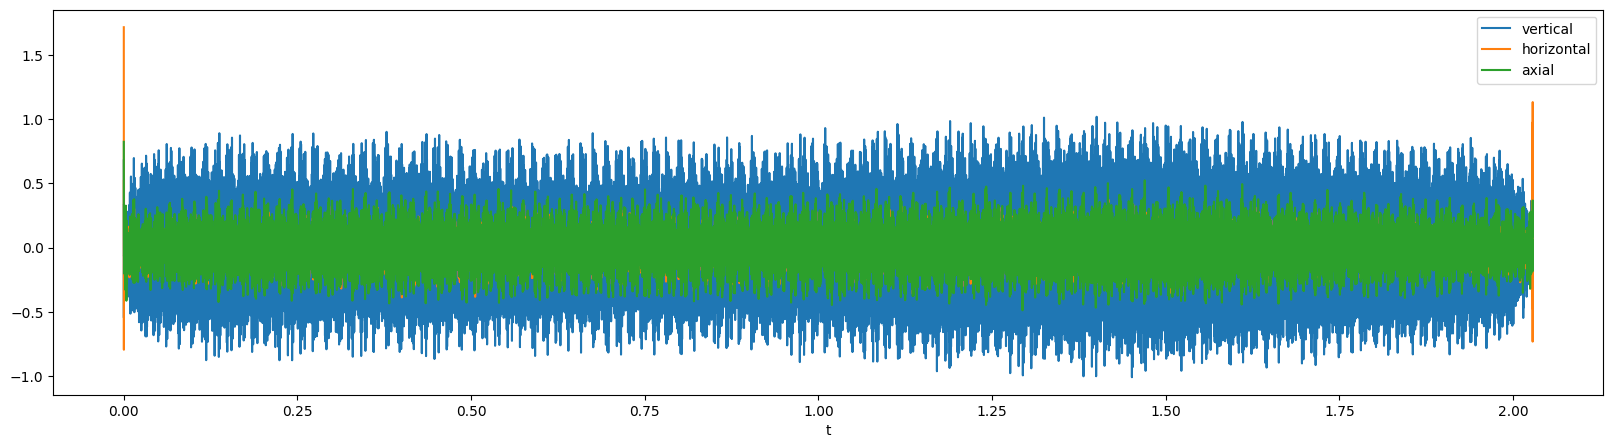

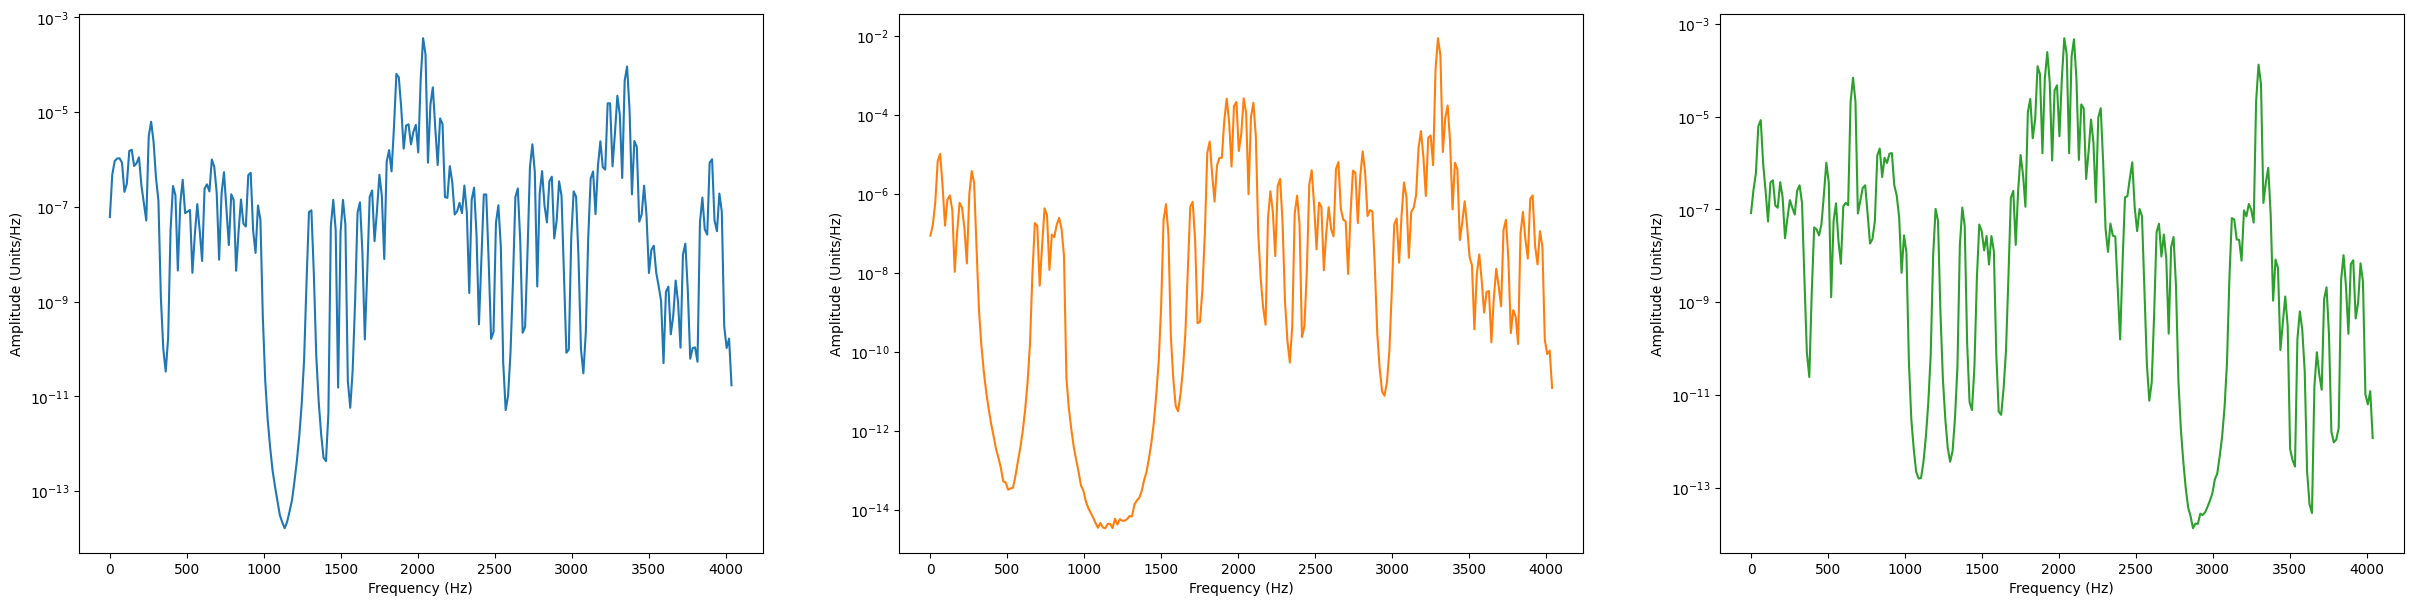

In [14]:
i = 0
w = 512
data = testDataDict[test_metadata["sample_id"][i]]

data.plot(figsize=(20,5))
#plt.title(metadata["condition"][i])

f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=w,overlap_factor=0.5)
P_g = np.array([Ph, Pv, Pa])

fig, axs = plt.subplots(1, 3, figsize=(30, 7))
for j, ax in enumerate(axs):
    ax.semilogy(f, P_g[j], color='C'+str(j))
    #ax.set_title(metadata["condition"][i] + " - " + data.columns[j])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (Units/Hz)')